In [1]:
import joblib
import pandas as pd

# Load the saved model and vectorizer from the same folder as the notebook
model = joblib.load('nlp_model.joblib')
vectorizer = joblib.load('vectorizer.joblib')
pipeline = joblib.load('nlp_pipeline_with_smote.joblib')



In [5]:
# Load your new dataset of job descriptions (CSV example)
# Replace with your actual file path and dataset of jobs
df_new_jobs = pd.read_csv('C://Users//roryq//Downloads//Final_Public_Data (2).csv')  # Replace with your file path

In [7]:
# Remove specified columns
df_new_jobs = df_new_jobs.drop(columns=['DataBuyerScore', 'PredictedDataBuyer'])


In [8]:
df_new_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5829 entries, 0 to 5828
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   JobID                    5829 non-null   int64 
 1   JobTitle                 5829 non-null   object
 2   JobDescription           5827 non-null   object
 3   KeyDuties                5829 non-null   object
 4   Department               5829 non-null   object
 5   Agency                   5829 non-null   object
 6   SearchKeywords           5829 non-null   object
 7   CombinedText             5829 non-null   object
 8   IsDataBuyer              5829 non-null   int64 
 9   FuzzyMatchedPhrase       938 non-null    object
 10  IsFuzzyMatch             5829 non-null   int64 
 11  IsLikelyDataBuyer        5829 non-null   int64 
 12  AgencySize               5829 non-null   object
 13  Industry                 5829 non-null   object
 14  IsSeniorRole             5829 non-null  

In [10]:
# Select features (same as during training)
X_new = df_new_jobs[['CombinedText', 'AgencySize', 'Industry', 'IsSeniorRole',
                     'UseCase_Fraud', 'UseCase_AdTargeting', 'UseCase_PatientMatching', 'UseCase_Sentiment']]

# Step 1: Get predicted probabilities for class 1 (likely data buyer)
probs = pipeline.predict_proba(X_new)[:, 1]  # Must come before assignment below

# Step 2: Transform and predict binary labels
X_new_transformed = pipeline.named_steps['preprocessor'].transform(X_new)
predictions = pipeline.named_steps['classifier'].predict(X_new_transformed)

# Step 3: Add results to the DataFrame
df_new_jobs['DataBuyerScore'] = probs
df_new_jobs['predicted_label'] = predictions

# Step 4: Filter rows predicted as data buyers
data_buying_jobs = df_new_jobs[df_new_jobs['predicted_label'] == 1]


In [11]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# Define X and y from the raw data
X = df_new_jobs[['CombinedText', 'AgencySize', 'Industry', 'IsSeniorRole', 'UseCase_Fraud','UseCase_AdTargeting','UseCase_PatientMatching', 'UseCase_Sentiment']]
y = df_new_jobs['IsLikelyDataBuyer']

# Scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

# Run cross-validation on the pipeline (not the transformed matrix)
cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)

# Display results
import pandas as pd
summary_df = pd.DataFrame({metric: cv_results[f'test_{metric}'] for metric in scoring})
summary_df.loc['mean'] = summary_df.mean()
summary_df.loc['std'] = summary_df.std()

print(summary_df.round(4))

      accuracy  precision  recall      f1  roc_auc
0       0.8722     0.9231  0.1978  0.3258   0.8502
1       0.8662     0.9091  0.1639  0.2778   0.8670
2       0.8679     0.9394  0.1694  0.2870   0.8722
3       0.8705     0.8333  0.2186  0.3463   0.8506
4       0.8592     0.8000  0.1319  0.2264   0.8474
mean    0.8672     0.8810  0.1763  0.2927   0.8575
std     0.0045     0.0544  0.0297  0.0415   0.0101


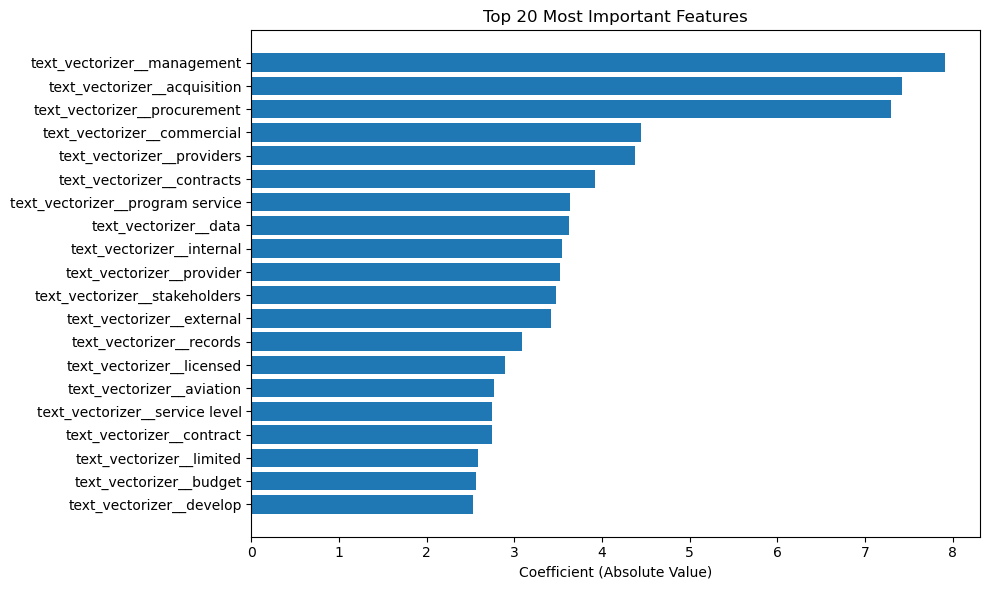

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get the fitted preprocessor and classifier
preprocessor = pipeline.named_steps['preprocessor']
classifier = pipeline.named_steps['classifier']

# Step 2: Get full feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Step 3: Get classifier coefficients
coefficients = classifier.coef_[0]  # for binary classification

# Step 4: Check that lengths match
assert len(feature_names) == len(coefficients), f"{len(feature_names)} features, but {len(coefficients)} coefficients"

# Step 5: Create DataFrame and sort by importance
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['AbsCoeff'] = coef_df['Coefficient'].abs()
top_n = 20
top_features = coef_df.sort_values('AbsCoeff', ascending=False).head(top_n)

# Step 6: Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.xlabel('Coefficient (Absolute Value)')
plt.title('Top 20 Most Important Features')
plt.grid(False)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import numpy as np

# Define X and y
X = df_new_jobs[['CombinedText', 'AgencySize', 'Industry', 'IsSeniorRole',
                 'UseCase_Fraud','UseCase_AdTargeting','UseCase_PatientMatching','UseCase_Sentiment']]
y = df_new_jobs['IsLikelyDataBuyer']

# Add log loss to scoring
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'neg_log_loss': 'neg_log_loss'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

# Run cross-validation
cv_results = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)

# Convert to DataFrame and adjust log loss
results_df = pd.DataFrame({metric: cv_results[f'test_{metric}'] for metric in scoring})
results_df['log_loss'] = -1 * results_df['neg_log_loss']
results_df = results_df.drop(columns=['neg_log_loss'])

# Add mean and std rows
results_df.loc['mean'] = results_df.mean()
results_df.loc['std'] = results_df.std()

# Show results
print(results_df.round(4))


      accuracy  precision  recall      f1  roc_auc  log_loss
0       0.8722     0.9231  0.1978  0.3258   0.8502    0.3203
1       0.8662     0.9091  0.1639  0.2778   0.8670    0.3200
2       0.8679     0.9394  0.1694  0.2870   0.8722    0.3148
3       0.8705     0.8333  0.2186  0.3463   0.8506    0.3211
4       0.8592     0.8000  0.1319  0.2264   0.8474    0.3312
mean    0.8672     0.8810  0.1763  0.2927   0.8575    0.3215
std     0.0045     0.0544  0.0297  0.0415   0.0101    0.0054
